In [631]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import plotly
import plotly.express as px
print(plotly.__version__)

import statistics
import category_encoders as ce

# тесты для отбра признаков
from sklearn.feature_selection import chi2 # хи-квадрат
from sklearn.feature_selection import f_classif # anova

#библиотеки для обработки текста
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

#библиотеки для нормализации признаков
from sklearn import preprocessing

import geopy.distance # библиотека для вычисления расстояния между точками координат

# инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

5.7.0


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/belov_engineer/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [632]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [633]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 1. Подгрузка и предварительный анализ данных

In [634]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv')
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')

In [635]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [636]:
df_train.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671


In [637]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [638]:
df_test.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102


In [639]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [640]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [641]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [642]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [643]:
#для первичного анализа данных использую библиотеку Pandas-profiling
import pandas as pd
from pandas_profiling import ProfileReport

In [644]:
profile = ProfileReport(data.drop('sample',axis=1), title="Booking hotels report")
profile

<b>Предварительный анализ входных данных:</b>  
* Всего в датасете 515738 отзывов.  
* 10 числовых признаков, 8 категориальных.  
* Пропуски в 6536 строках в признаках lat и lng.   
* Всего 336 дубликатов.   
* Категориальных признаков - 8, числовых - 9.   
* Высокая корреляция между признаком additional_number_of_scoring и рядом других признаков.  
* В данных собраны отзывы о 1493 разных отеля. Есть отели с одинаковыми названиями.   

Признаки

* hotel_address - адрес отеля  
* review_date - дата, когда рецензент разместил соответствующий отзыв.
* average_score - средний балл отеля, рассчитанный на основе последнего комментария за последний год
* hotel_name - название отеля
* reviewer_nationality - национальность рецензента
* negative_review - отрицательный отзыв, который рецензент дал отелю.
* review_total_negative_word_counts - общее количество слов в отрицательном отзыв
* positive_review - положительный отзыв, который рецензент дал отелю
    review_total_positive_word_counts - общее количество слов в положительном отзыве
* reviewer_score - оценка, которую рецензент поставил отелю на основе своего опыта
* total_number_of_reviews_reviewer_has_given - количество отзывов, которые рецензенты дали в прошлом
* total_number_of_reviews - общее количество действительных отзывов об отеле
* tags - теги, которые рецензент дал отелю.
* days_since_review - продолжительность между датой проверки и датой очистки
* additional_number_of_scoring - есть также некоторые гости, которые просто поставили оценку сервису, а не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat - широта отеля
* lng - долгота отеля


# 2. Очистка данных

In [645]:
#избавляюсь от дубликатов
data.drop_duplicates(inplace=True)

In [646]:
#ищу отели с одинаковым названиями, но разными адресами
grouped_data = data.groupby(['hotel_name','hotel_address'])['sample'].count().sort_values()

In [647]:
grouped_data.groupby('hotel_name').count().sort_values(ascending=False)

hotel_name
Hotel Regina                               3
pentahotel Vienna                          1
Haymarket Hotel                            1
H10 Urquinaona Plaza                       1
HCC Regente                                1
                                          ..
Mercure Paris Op ra Faubourg Montmartre    1
Mercure Paris Opera Garnier                1
Mercure Paris Opera Grands Boulevards      1
Mercure Paris Opera Louvre                 1
11 Cadogan Gardens                         1
Name: sample, Length: 1492, dtype: int64

In [648]:
data[data['hotel_name'] == 'Hotel Regina']['hotel_address'].unique()

array(['Bergara 2 4 Eixample 08002 Barcelona Spain',
       'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria',
       'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy'],
      dtype=object)

Три отеля, расположенные в разных городах, называются одинаково Hotel Regina. Чтобы использовать название отеля в качестве ключа, изменю названия отелей. 

In [649]:
data.loc[(data['hotel_address'] == 'Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria'),'hotel_name'] = 'Hotel Regina in Vienna'

In [650]:
data.loc[(data['hotel_address'] == 'Via Cesare Correnti 13 Milan City Center 20123 Milan Italy'),'hotel_name'] = 'Hotel Regina in Milan'

# 3. Обработка признаков

# Признак hotel_address

In [651]:
#выделяю страну и название города из адреса отеля
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.endswith('United Kingdom') else x.split()[-2])
data['hotel_country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
data.drop('hotel_address',axis=1, inplace=True)

In [652]:
#сводная таблица распределения городов отелей по странам
pd.pivot_table(data, values = 'sample',
               index = ['hotel_country','hotel_city'], 
               aggfunc = 'count')

,,sample
hotel_country,hotel_city,
Austria,Vienna,38938
France,Paris,59598
Italy,Milan,37206
Netherlands,Amsterdam,57212
Spain,Barcelona,60149
United Kingdom,London,262299


Одной стране соответствует один город. Соответственно, надо будет закодировать только один из признаков.

Строю график распределения отелей по странам с учетом того, что по каждому отелю в данных существует некоторое количество отзывов.

In [653]:
#для построения графика группирую отели по названию и стране 
country_hotels = data.groupby(['hotel_name','hotel_country'],as_index=False)['sample'].count()
country_hotels

,hotel_name,hotel_country,sample
0,11 Cadogan Gardens,United Kingdom,159
1,1K Hotel,France,148
2,25hours Hotel beim MuseumsQuartier,Austria,689
3,41,United Kingdom,103
4,45 Park Lane Dorchester Collection,United Kingdom,28
...,...,...,...
1489,citizenM London Bankside,United Kingdom,1517
1490,citizenM London Shoreditch,United Kingdom,838
1491,citizenM Tower of London,United Kingdom,1683
1492,every hotel Piccadilly,United Kingdom,568


In [654]:
#данные для построения графика о распределении отелей по странам
country_hotels_grouped = country_hotels.groupby('hotel_country',as_index=False)['hotel_name'].count()
country_hotels_grouped.rename(columns={'hotel_name':'hotels_number'},inplace=True)
country_hotels_grouped

,hotel_country,hotels_number
0,Austria,158
1,France,458
2,Italy,162
3,Netherlands,105
4,Spain,211
5,United Kingdom,400


In [655]:
#строю график
fig = px.bar(
    data_frame=country_hotels_grouped, 
    x='hotel_country',
    y='hotels_number', 
    color='hotel_country', 
    text = 'hotels_number', 
    orientation='v', 
    height=500, 
    width=1000, 
    title='Распределение отелей по странам' 
)

#отображаем его
fig.show()

Больше всего отелей расположены во Франции и Великобритании.

In [656]:
#кодирую город отеля методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['hotel_city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(data['hotel_city'])
data = pd.concat([data, type_bin], axis=1)

In [657]:
#последний признак hotel_city_6 можно удалить, как неинформативный, поскольку исключение первых пяти однозначно определяет шестой город
data.drop('hotel_city_6',axis=1,inplace=True)

# Замена пустых значений признаков lat и lng на средний по городу

In [658]:
#получаю средние значение координат отелей для каждого города
data_cleaned = data.dropna(axis=0)
data_grouped = data_cleaned.groupby(by='hotel_city',as_index=False)['lat','lng'].mean()

data_grouped.head()

/tmp/ipykernel_172841/2889834430.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,hotel_city,lat,lng
0,Amsterdam,52.362208,4.885409
1,Barcelona,41.389079,2.169147
2,London,51.510739,-0.138960
3,Milan,45.479615,9.191835
4,Paris,48.863836,2.326802


In [659]:
#заменяю пропущенные значения координат средними по городу
data = data.merge(data_grouped, on='hotel_city', how='left')
values = {
    'lat_x': data['lat_y'],
    'lng_x': data['lng_y']
}
data = data.fillna(values)

data.drop(['lat_y','lng_y'], axis=1, inplace=True)

# Признак расстояния от отеля до центра города

In [660]:
# создаю словарь с координатами центров городов (координаты получены из Google Map)
city_coordinates = {'Amsterdam': (52.37016, 4.90062),
 'Barcelona': (41.37527, 2.149),
 'London': (51.50321, -0.15145),
 'Milan': (45.47261, 9.18510),
 'Paris': (48.86423, 2.33676),
 'Vienna': (48.18855, 38176)}

In [661]:
# вычисляю расстояние до центра города
data['distance_to_center'] = data.apply(lambda x: geopy.distance.geodesic((x.lat_x, x.lng_x), city_coordinates[x.hotel_city]).m, axis=1)

In [662]:
data['distance_to_center'].value_counts().head(10)

8904.977124     4789
2297.615853     4256
2433.395616     4169
2833.547553     3577
5165.836619     3212
2572.686530     2958
2899.102640     2768
27350.594296    2679
2250.660324     2628
2469.493494     2565
Name: distance_to_center, dtype: int64

In [663]:
#распределение расстояния от отелей до центра города
#выделяю уникальные значения для каждого отеля
hotels_distance = data[['hotel_name','distance_to_center']]

In [664]:
#удаляю дубликаты, чтобы оставить уникальные строки для каждого отеля
hotels_distance = hotels_distance.drop_duplicates()

Text(0.5, 1.0, 'Расстояния до центра')

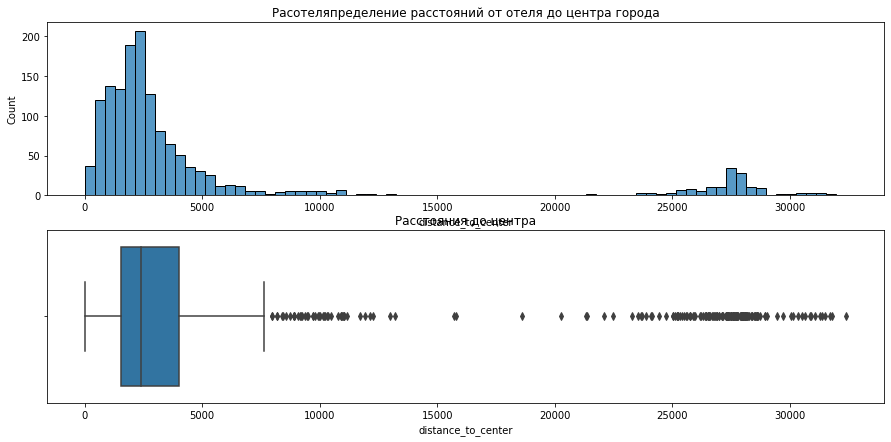

In [665]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))
histplot = sns.histplot(data=hotels_distance, x='distance_to_center', ax=axes[0])
histplot.set_title('Расотеляпределение расстояний от отеля до центра города')
boxplot = sns.boxplot(data=hotels_distance, x='distance_to_center', ax=axes[1])
boxplot.set_title('Расстояния до центра')

In [666]:
#использую метод MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
hotels_distance['norm_distance_to_center'] = mm_scaler.fit_transform(hotels_distance[['distance_to_center']])

In [667]:
#добавляю новый признак в датасет
hotels_distance.drop('distance_to_center',axis=1,inplace=True)
data = data.merge(hotels_distance, on='hotel_name',how='left')

<AxesSubplot:xlabel='norm_distance_to_center', ylabel='Count'>

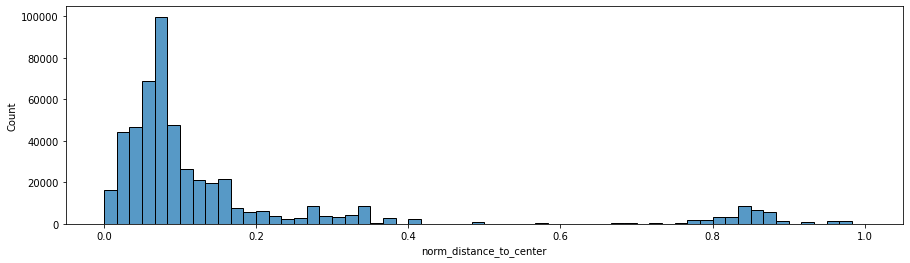

In [668]:
fig = plt.figure(figsize=(15, 4))
sns.histplot(data['norm_distance_to_center'], bins=60)

In [669]:
#удаляю ненормализованный признак из датасета
data.drop('distance_to_center',axis=1,inplace=True)

In [670]:
#удаляю признаки со значениями координат
data.drop(['lat_x','lng_x'], axis=1, inplace=True)

# Признаки страна рецензента и соответствие страны рецензента стране отеля

In [671]:
#выясняю сколько всего национальностей рецензентов 
len(data['reviewer_nationality'].unique())


227

In [672]:
#данные для построения графика
bar_data = data.groupby('reviewer_nationality',as_index=False
)[['sample']].count().nlargest(15, columns=['sample'])
bar_data.rename(columns={'sample':'reviewer_number'},inplace=True)
bar_data

,reviewer_nationality,reviewer_number
214,United Kingdom,245158
216,United States of America,35385
14,Australia,21662
98,Ireland,14819
213,United Arab Emirates,10230
176,Saudi Arabia,8945
144,Netherlands,8762
197,Switzerland,8672
78,Germany,7934
38,Canada,7886


In [673]:
#строю график распределения рецензентов по странам
fig = px.bar(
    data_frame=bar_data, 
    x="reviewer_nationality", 
    y="reviewer_number", 
    color='reviewer_nationality', 
    text = 'reviewer_number', 
    orientation='v', 
    height=500, 
    width=1000, 
    title='Распределение национальности рецензентов' 
)

#отображаем его
fig.show()

Подавляющее количество рецензентов имеют гражданство Великобритании, затем США и Австралии.

In [674]:
#обработаю признак, чтобы убрать пробелы в начале и конце строки
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

In [675]:
#добавляю признак соответствия национальности рецензента стране отеля
data['country_nationality_accordance'] = (data['hotel_country'] == data['reviewer_nationality']).astype(int)

In [676]:
#оставлю 10 наиболее часто встречающихся национальностей. Остальные поменяю на Other
top_ten = data['reviewer_nationality'].value_counts().nlargest(10).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_ten else 'Other')

In [677]:
data['reviewer_nationality'].unique()

array(['United Kingdom', 'Other', 'United States of America',
       'Netherlands', 'Ireland', 'Canada', 'Australia', 'Saudi Arabia',
       'Germany', 'United Arab Emirates', 'Switzerland'], dtype=object)

In [678]:
#кодирую признак национальности рецензента методом двоичного кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)


In [679]:
data.drop(['hotel_city','hotel_country','reviewer_nationality'],axis=1,inplace=True)

# Признак даты отзыва

In [680]:
#выделяю месяц, когда был написан отзыв
data['review_date'] = pd.to_datetime(data['review_date'])
data['review_month'] = data['review_date'].dt.month

In [681]:
#дата самого раннего отзыва
data['review_date'].min()

Timestamp('2015-08-04 00:00:00')

In [682]:
#дата последнего отзыва
data['review_date'].max()

Timestamp('2017-08-03 00:00:00')

In [683]:
#кодирую признак в высокий или низкий сезон состоялось посещение отеля
data['high_season'] = data['review_month'].apply(lambda x: 1 if x in [1,5,6,7,8,9] else 0)

# Признак срока давности отзыва

In [684]:
#вычисляю признак давности отзыва в месяцах относительно даты последнего отзыва
from datetime import datetime
data['age_of_review'] = data['review_date'] - data['review_date'].min()
data['age_of_review'] = data['age_of_review'].astype(str)
data['age_of_review'] = data['age_of_review'].apply(lambda x: x.split()[0])
data['age_of_review'] = round(data['age_of_review'].astype(int) / 30)

In [685]:
data['age_of_review'].min()

0.0

<AxesSubplot:xlabel='age_of_review', ylabel='Count'>

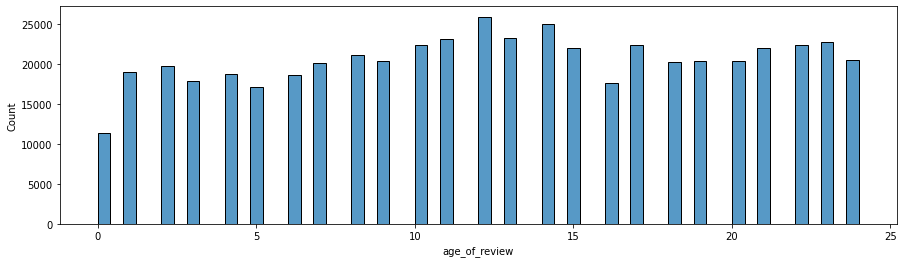

In [686]:
fig = plt.figure(figsize=(15, 4))
sns.histplot(data['age_of_review'], bins=60)

In [687]:
# удаляю признак даты отзыва
data.drop(['review_date','review_month'],axis=1,inplace=True)

In [688]:
#применяю RobustScaler к признаку "возраста" отзыва
r_scaler = preprocessing.RobustScaler()
data['age_of_review'] = r_scaler.fit_transform(data[['age_of_review']])

# Признак Отрицательный отзыв

In [689]:
#обрабатываю признак, чтобы убрать пробелы в начале и конце строки
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip())

In [690]:
#проверяю, какие негативные отзывы наиболее часто втречаются
data['negative_review'].value_counts().nlargest(10)

No Negative       127807
Nothing            18525
nothing             2506
None                1166
N A                 1060
                     849
Nothing really       569
N a                  520
All good             469
Small room           455
Name: negative_review, dtype: int64

In [691]:
#список ложных отрицательных отзывов 
false_negative = ['We loved everything','not much','Leaving','Was all good','','Coming home','Noting','absolutely nothing','nothing all good','Nothing all great','Nothing It was perfect','Can t think of s thing','Nothing everything was great','No problems at all','All was great','Nothing All good','Not a lot','I liked it all','Cannot think of anything','Nothing negative to say','No comments','Liked it all','Going home','All great','Nothing could have been better','Nothing bad to say','Everything was excellent','No dislikes','Nothing to say','There was nothing we didn t like','All ok','no complaints','No complaints at all','There was nothing to dislike','Nothing I didn t like','As above','nothing really','It was all good','Nothing not to like','Having to leave','Nothing all good','Nothing could have been improved','Can t think of anything really','No Negative','Nothing','nothing','None','N A',' ','Nothing really','N a','All good','No complaints',
                  'Nothing at all','Nothing to dislike','none','Nil','Everything was perfect','Can t think of anything',
                 'n a','Absolutely nothing','Everything was great','Nothing to complain about','NA','NOTHING','I liked everything',
                 'No','Liked everything','Not much','Everything was good','See above','Nothing in particular','Everything was fine','Na',
                 'All was good','Nothing it was perfect','Not applicable','Non','Nothing comes to mind','There was nothing I didn t like',
                 'We liked everything','Nothing everything was perfect','No negatives','Nothing everything was great','Nothing to report',
                 'Not a thing','Loved everything','No thing','all good','There was nothing not to like','No issues','Nothing I can think of',
                 'No bad experience','Nothing to mention','no','No comment','Nothing we didn t like','Nothing to complain','No problems',
                 'I loved everything','nil','nothing at all','nothing bad','Couldn t fault it','Nothing to fault','It was perfect',
                 'Nothing Everything was perfect','There wasn t anything we didn t like','nothing to dislike','Nothing much','non',
                 'That we couldn t stay longer','That we had to leave','No bad experiences','Loved it all','That I couldn t stay longer',
                 'I have no complaints','Nothing it was all good','I can t think of anything','Nothing that I can think of','Nothing of note',
                 'Couldn t fault anything','nothing to complaint about','All was perfect','I had to leave','That I had to leave','Very little','leaving',
                 'everything was perfect','There wasn t anything I didn t like','Having to go home','Nithing','Nothing all was great',
                 'Everything was very good','No complaints whatsoever','Everything was fantastic','Could not fault anything','No complains',
                 'Can t think of any','Nope','Nothing specific','everything was great','no thing','Everything perfect','Can t fault it',
                 'Happy with everything','No one thing','Everything good','Nothing everything was good','There is nothing to dislike',
                 'Nothing I did not like','Nothing to note','Nothings','Nothing all perfect','Nothing bad to report','I','Nothing was bad',
                 'all ok','Nothing to complain about at all','Nothing that I didn t like','Nothinh','We had to leave','Nothing everything was excellent',
                 'There wasn t anything to not to like', 'Can t think of anything I didn t like','I loved it all','Having to come home',
                 'Nothing bad at all','nothing in particular','All very good','nothing comes to mind','There was nothing','Everything was just perfect',
                 'Nothing to say here','Nothing all excellent','I don t know','No faults at all','Wish we could stay longer','Nothing loved it all',
                 'Norhing','Nothing All was great','nothing to say','There wasn t anything','Almost nothing','No things','Nothing that we didn t like',
                 'Nothing to comment','All OK','Not much really','Nothing as such','Nothing to improve','Honestly nothing','Nowt','Nothing to add',
                 'My stay was too short','Nothing it was amazing','I like everything','Nothing so far','nothing to mention','All is good',
                 'Had to leave','nope']

In [692]:
#создаю признак наличия либо отсутствия негативного отзыва
data['negative_review_exists'] = data['negative_review'].apply(lambda x: 0 if x in false_negative else 1 )

# Признак Процент истиных негативных отзывов по каждому отелю

In [693]:
#групирую данные
grouped = data.groupby(['hotel_name','total_number_of_reviews'],as_index=False)['negative_review_exists'].sum()
grouped.head(2)

,hotel_name,total_number_of_reviews,negative_review_exists
0,11 Cadogan Gardens,393,96
1,1K Hotel,663,122


In [694]:
#считаю процент истиных негативных отзывов по каждому отелю
grouped['%_of_negative_reviews'] = grouped['negative_review_exists'] / grouped['total_number_of_reviews']

<AxesSubplot:>

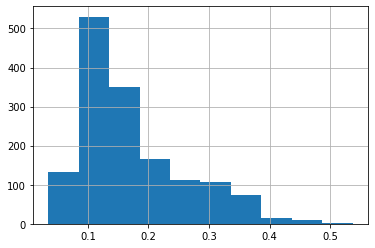

In [695]:
grouped['%_of_negative_reviews'].hist()

In [696]:
grouped['%_of_negative_reviews'].median()

0.14376537372463755

In [697]:
#добавляю признак в данные
grouped.drop(['total_number_of_reviews','negative_review_exists'],axis=1,inplace=True)
data = data.merge(grouped, on='hotel_name',how='left')

<AxesSubplot:>

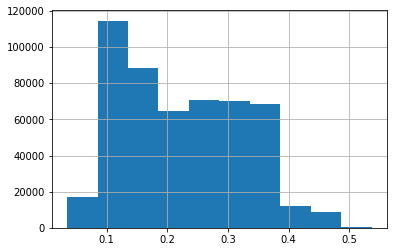

In [698]:
data['%_of_negative_reviews'].hist()

In [699]:
data['%_of_negative_reviews'].median()

0.2176696542893726

# Признак Положительный отзыв

In [700]:
#обработаю признак, чтобы убрать пробелы в начале и конце строки
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip())

In [701]:
#проверяю, какие позитивные отзывы наиболее часто втречаются
data['positive_review'].value_counts().nlargest(10)

No Positive       35923
Location          10126
Everything         2897
location           1733
Nothing            1466
Great location     1417
The location       1338
Good location      1202
Breakfast           664
Friendly staff      602
Name: positive_review, dtype: int64

In [702]:
#список ложных положительных отзывов
false_positive = ['No Positive','Nothing','nothing','Not much','']

In [703]:
#создаю признак наличия либо отсутствия истиного положительного отзыва
data['positive_review_exists'] = data['positive_review'].apply(lambda x: 0 if x in false_positive else 1 )

# Признак Процент истиных положительных отзывов

In [704]:
grouped = data.groupby(['hotel_name','total_number_of_reviews'],as_index=False)['positive_review_exists'].sum()
grouped.head(2)

,hotel_name,total_number_of_reviews,positive_review_exists
0,11 Cadogan Gardens,393,149
1,1K Hotel,663,134


In [705]:
grouped['%_of_positive_reviews'] = grouped['positive_review_exists'] / grouped['total_number_of_reviews']

<AxesSubplot:>

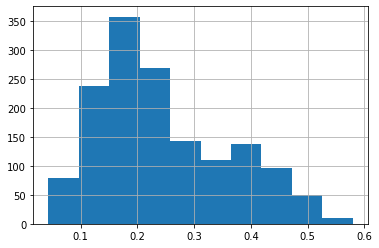

In [706]:
grouped['%_of_positive_reviews'].hist()

In [707]:
#добавляю новый признак в датасет
grouped.drop(['total_number_of_reviews','positive_review_exists'],axis=1,inplace=True)
data = data.merge(grouped, on='hotel_name',how='left')

<AxesSubplot:>

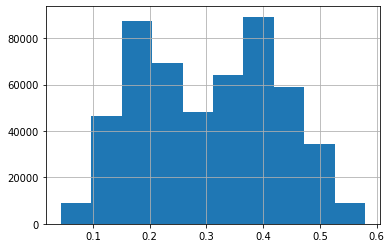

In [708]:
data['%_of_positive_reviews'].hist()

In [709]:
data.drop(['total_number_of_reviews'],axis=1,inplace=True)

# Признаки процентного содержания негативных и позитивных слов в отзыве

In [710]:
#поскольку количество слов в негативных и позитивных отзывах, указанное в признаках не соответствует действительности, пересчитаю эти значения
data['review_total_negative_word_counts'] = data['negative_review'].apply(lambda x: len(x.split()))
data['review_total_positive_word_counts'] = data['positive_review'].apply(lambda x: len(x.split()))

In [711]:
#заменяю значение количества слов в ложных негативных отзывах на 0
data.loc[(data['negative_review_exists'] == 0), 'review_total_negative_word_counts'] = 0
data.loc[(data['positive_review_exists'] == 0), 'review_total_positive_word_counts'] = 0

In [712]:
data[['negative_review','review_total_negative_word_counts','positive_review','review_total_positive_word_counts']].head(6)

,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts
0,Would have appreciated a shop in the hotel tha...,50,Hotel was great clean friendly staff free brea...,60
1,No tissue paper box was present at the room,9,No Positive,0
2,Pillows,1,Nice welcoming and service,4
3,No Negative,0,Everything including the nice upgrade The Hote...,26
4,No Negative,0,Lovely hotel v welcoming staff,5
5,They don t have free wifi,6,The location is perfect if you don t have a lo...,24


In [713]:
data['review_total_negative_word_counts'].max()

406

In [714]:
#проверяю, что отзывы длинной в несколько сотен слов это реальные отзывы, а не случайные выбросы
data[data['review_total_negative_word_counts'] > 300]['negative_review'].unique()[0]

'Hotel Vienna is overall supposed to be Viennese semi luxury but actually it is totally outdated with some 90 s updates which makes it even worst in terms of deco style and appearance The corridors are with heavy old carpets and smell although there is no smoking looks like no one follows the rules even the staff Only 1 small lift for cutest and staff which is slow and smells all the time The rooms are not as spacious as it looks on the photos advertised they have used the usual advertisements tricks The coffe and Tea advertised as complimentary are just one off after that if you whant to have every day you need to pay for it There is a coffeemaker and a kettle too The mini bar is totally overpriced The cleaning services are daily but if you whant your bedding and towering change you need to ask for it The heating is very hot you need to adgest it yourself or ask receptionist they are no guides for it There are no wardrobes but more like a small box with few hangers 1 chair and 1 small

In [715]:
#вычисляю процент содержания негативных и позитивных слов в отзыве
data['%_of_negative_words'] = data['review_total_negative_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])
data['%_of_positive_words'] = data['review_total_positive_word_counts'] / (data['review_total_negative_word_counts'] + data['review_total_positive_word_counts'])

In [716]:
#проверяю признаки на наличие пропусков
cols_null_percent = data[['%_of_negative_words','%_of_positive_words']].isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

%_of_positive_words    0.093519
%_of_negative_words    0.093519
dtype: float64

In [717]:
#заменяю пропуски на 0
data['%_of_negative_words'] = data['%_of_negative_words'].fillna(0)
data['%_of_positive_words'] = data['%_of_positive_words'].fillna(0)

In [718]:
#проверяю признаки на наличие np.inf значений
np.all(np.isfinite(data[['%_of_negative_words','%_of_positive_words']]))

True

array([[<AxesSubplot:title={'center':'%_of_negative_words'}>,
        <AxesSubplot:title={'center':'%_of_positive_words'}>]],
      dtype=object)

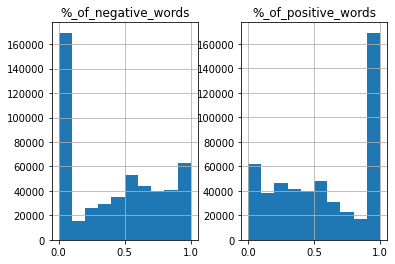

In [719]:
data[['%_of_negative_words','%_of_positive_words']].hist()


# Признак разности количества слов в положительном и отрицательном отзывах

In [720]:
data['dif_of_positive_negative'] = (data['review_total_positive_word_counts'] + 1) / (data['review_total_negative_word_counts'] + 1) / 100

<AxesSubplot:>

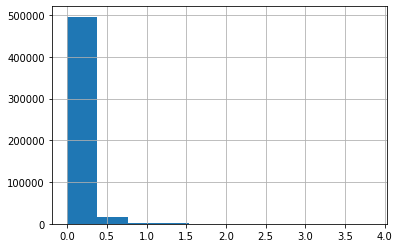

In [721]:
data['dif_of_positive_negative'].hist()

# Признаки удовлетворенности рецензента отелем

In [722]:
# пакет символьной и статистической обработки текста для анализа отзывов
sent_analyzer = SentimentIntensityAnalyzer()

# анализ отзывов
data['negative_sent_review'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['positive_sent_review'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# записываю результаты в основной датафрейм в виде отдельных признаков
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['negative_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['positive_sent_review'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.head(3)

,additional_number_of_scoring,average_score,hotel_name,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,...,negative_sent_review,positive_sent_review,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,904,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel tha...,50,Hotel was great clean friendly staff free brea...,60,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.000,0.671,0.329,0.9615
1,612,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,9,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,...,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...",0.216,0.784,0.000,-0.2960,0.379,0.000,0.621,0.3400
2,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Pillows,1,Nice welcoming and service,4,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.26, 'pos': 0.74, 'compou...",0.000,1.000,0.000,0.0000,0.000,0.260,0.740,0.6908


In [723]:
data.drop(['negative_review','positive_review','negative_sent_review','positive_sent_review'],axis=1,inplace=True)

# Признак tags

In [724]:
data['tags'].unique()

array(["[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",
       "[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",
       "[' Business trip ', ' Solo traveler ', ' Twin Room ', ' Stayed 1 night ', ' Submitted from a mobile device ']",
       ...,
       "[' Business trip ', ' Family with older children ', ' Single Room ', ' Stayed 3 nights ', ' Submitted from a mobile device ']",
       "[' Leisure trip ', ' Solo traveler ', ' Luxury Room 1 Queensize Bed Twin bedded Room On Request ', ' Stayed 6 nights ', ' Submitted from a mobile device ']",
       "[' Leisure trip ', ' Couple ', ' Bunk Bed Room ', ' Stayed 4 nights ']"],
      dtype=object)

Закодирую 30 наиболее часто встречающихся тегов и обработаю получившиеся признаки.

In [725]:
#избавляюсь от прямых скобок
data['tags'] = data['tags'].apply(lambda x: x.strip('[]'))

In [726]:
#избавляюсь от кавычек и пробелов
data['tags'] = data['tags'].apply(lambda x: [w.strip(" '") for w in x.split(',')])

In [727]:
display(data['tags'])

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
515397    [Leisure trip, Group, Club Double or Twin Room...
515398    [Leisure trip, Couple, Standard Double Room, S...
515399    [Business trip, Solo traveler, Single Room, St...
515400    [Leisure trip, Solo traveler, Deluxe Double Ro...
515401    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 515402, dtype: object

In [728]:
#считаю количество одинаковых тегов
tags_dict = {}
def fill_tags_dict(x):
    for elem in x:
        if elem in tags_dict:
            tags_dict[elem] = tags_dict[elem] + 1
        else:
            tags_dict[elem] = 1
    return x
data['tags'].apply(fill_tags_dict) 

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
515397    [Leisure trip, Group, Club Double or Twin Room...
515398    [Leisure trip, Couple, Standard Double Room, S...
515399    [Business trip, Solo traveler, Single Room, St...
515400    [Leisure trip, Solo traveler, Deluxe Double Ro...
515401    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 515402, dtype: object

In [729]:
tags_dict

{'Leisure trip': 417513,
 'Couple': 252117,
 'Double Room': 35207,
 'Stayed 2 nights': 133846,
 'Group': 65357,
 'Triple Room': 4493,
 'Stayed 1 night': 193557,
 'Business trip': 82880,
 'Solo traveler': 108468,
 'Twin Room': 8320,
 'Submitted from a mobile device': 307458,
 'Ambassador Junior Suite': 8,
 'Classic Double or Twin Room': 6098,
 'Standard Double or Twin Room': 17478,
 'Queen Room': 5472,
 'Executive Room': 1293,
 'Stayed 3 nights': 95754,
 'Double or Twin Room': 22393,
 'Standard Triple Room': 1300,
 'Superior Double Room': 31359,
 'Large Room': 216,
 'Stayed 4 nights': 47774,
 'Superior King Room': 4248,
 'Junior Suite': 4555,
 'Royal Suite with Canal View': 53,
 'Stayed 7 nights': 7391,
 'Standard Single Room': 4615,
 'King Room': 2843,
 'Standard Double Room': 32246,
 'Deluxe Double or Twin Room': 5996,
 'Stayed 5 nights': 20825,
 'Family with young children': 60986,
 'Suite': 1897,
 'Basic Double Room': 2851,
 'Club Double Room': 5908,
 'Classic Room': 4416,
 'Family 

In [730]:
len(tags_dict)

2428

In [731]:
#создаю DataFrame, отсортированный по частоте втречаемости тегов
tags_count = pd.DataFrame(tags_dict,index=['count']).transpose()
tags_sorted = tags_count.sort_values(by='count', ascending=False).head(30)

In [732]:
display(tags_sorted)

,count
Leisure trip,417513
Submitted from a mobile device,307458
Couple,252117
Stayed 1 night,193557
Stayed 2 nights,133846
Solo traveler,108468
Stayed 3 nights,95754
Business trip,82880
Group,65357
Family with young children,60986


In [733]:
#создаю список наиболее часто встречающихся тегов
tags_30 = list(tags_sorted.index)

In [734]:
display(tags_30)

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children',
 'Stayed 4 nights',
 'Double Room',
 'Standard Double Room',
 'Superior Double Room',
 'Family with older children',
 'Deluxe Double Room',
 'Double or Twin Room',
 'Stayed 5 nights',
 'Standard Double or Twin Room',
 'Classic Double Room',
 'Superior Double or Twin Room',
 '2 rooms',
 'Stayed 6 nights',
 'Standard Twin Room',
 'Single Room',
 'Twin Room',
 'Stayed 7 nights',
 'Executive Double Room',
 'Classic Double or Twin Room',
 'Superior Twin Room']

In [735]:
#кодирую наиболее часто встречающиеся теги
for tag in tags_30:
    data[tag] = data['tags'].apply(lambda x: 1 if tag in x else 0)

In [736]:
#предположу, что продолжительность проживания в отеле в течении одного или двух дней может повлиять на характер оценки отеля
#удаляю ненужные признаки
data.drop(['Stayed 3 nights','Stayed 4 nights','Stayed 5 nights','Stayed 6 nights','Stayed 7 nights'], axis=1, inplace=True)

In [737]:
#объединяю теги для номеров одинаковой категории
#standard double or twin room
data['standard_double_twin_room'] = ((data['Double Room']==1)|(data['Standard Double Room']==1)|(data['Double or Twin Room']==1)|
                        (data['Standard Double or Twin Room']==1)|(data['Classic Double Room']==1)|(data['2 rooms']==1)|
                        (data['Standard Twin Room']==1)|(data['Twin Room']==1)|(data['Classic Double or Twin Room']==1)).astype(int)
data.drop(['Double Room','Standard Double Room','Double or Twin Room','Standard Double or Twin Room','Classic Double Room','2 rooms',
          'Standard Twin Room','Twin Room','Classic Double or Twin Room'],axis=1,inplace=True)
#superior double or twin room
data['superior_double_twin_room'] = ((data['Superior Double Room']==1)|(data['Superior Double or Twin Room'])|
                        (data['Superior Twin Room'])|(data['Deluxe Double Room'])).astype(int)
data.drop(['Superior Double Room','Superior Double or Twin Room','Superior Twin Room','Deluxe Double Room'],axis=1,inplace=True)

In [738]:
data.drop(['tags'], axis=1, inplace=True)

In [739]:
data_fixed = data.copy()

In [740]:
#data = data_fixed

# 5. Подготовка данных к обучению модели

In [741]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

<AxesSubplot:>

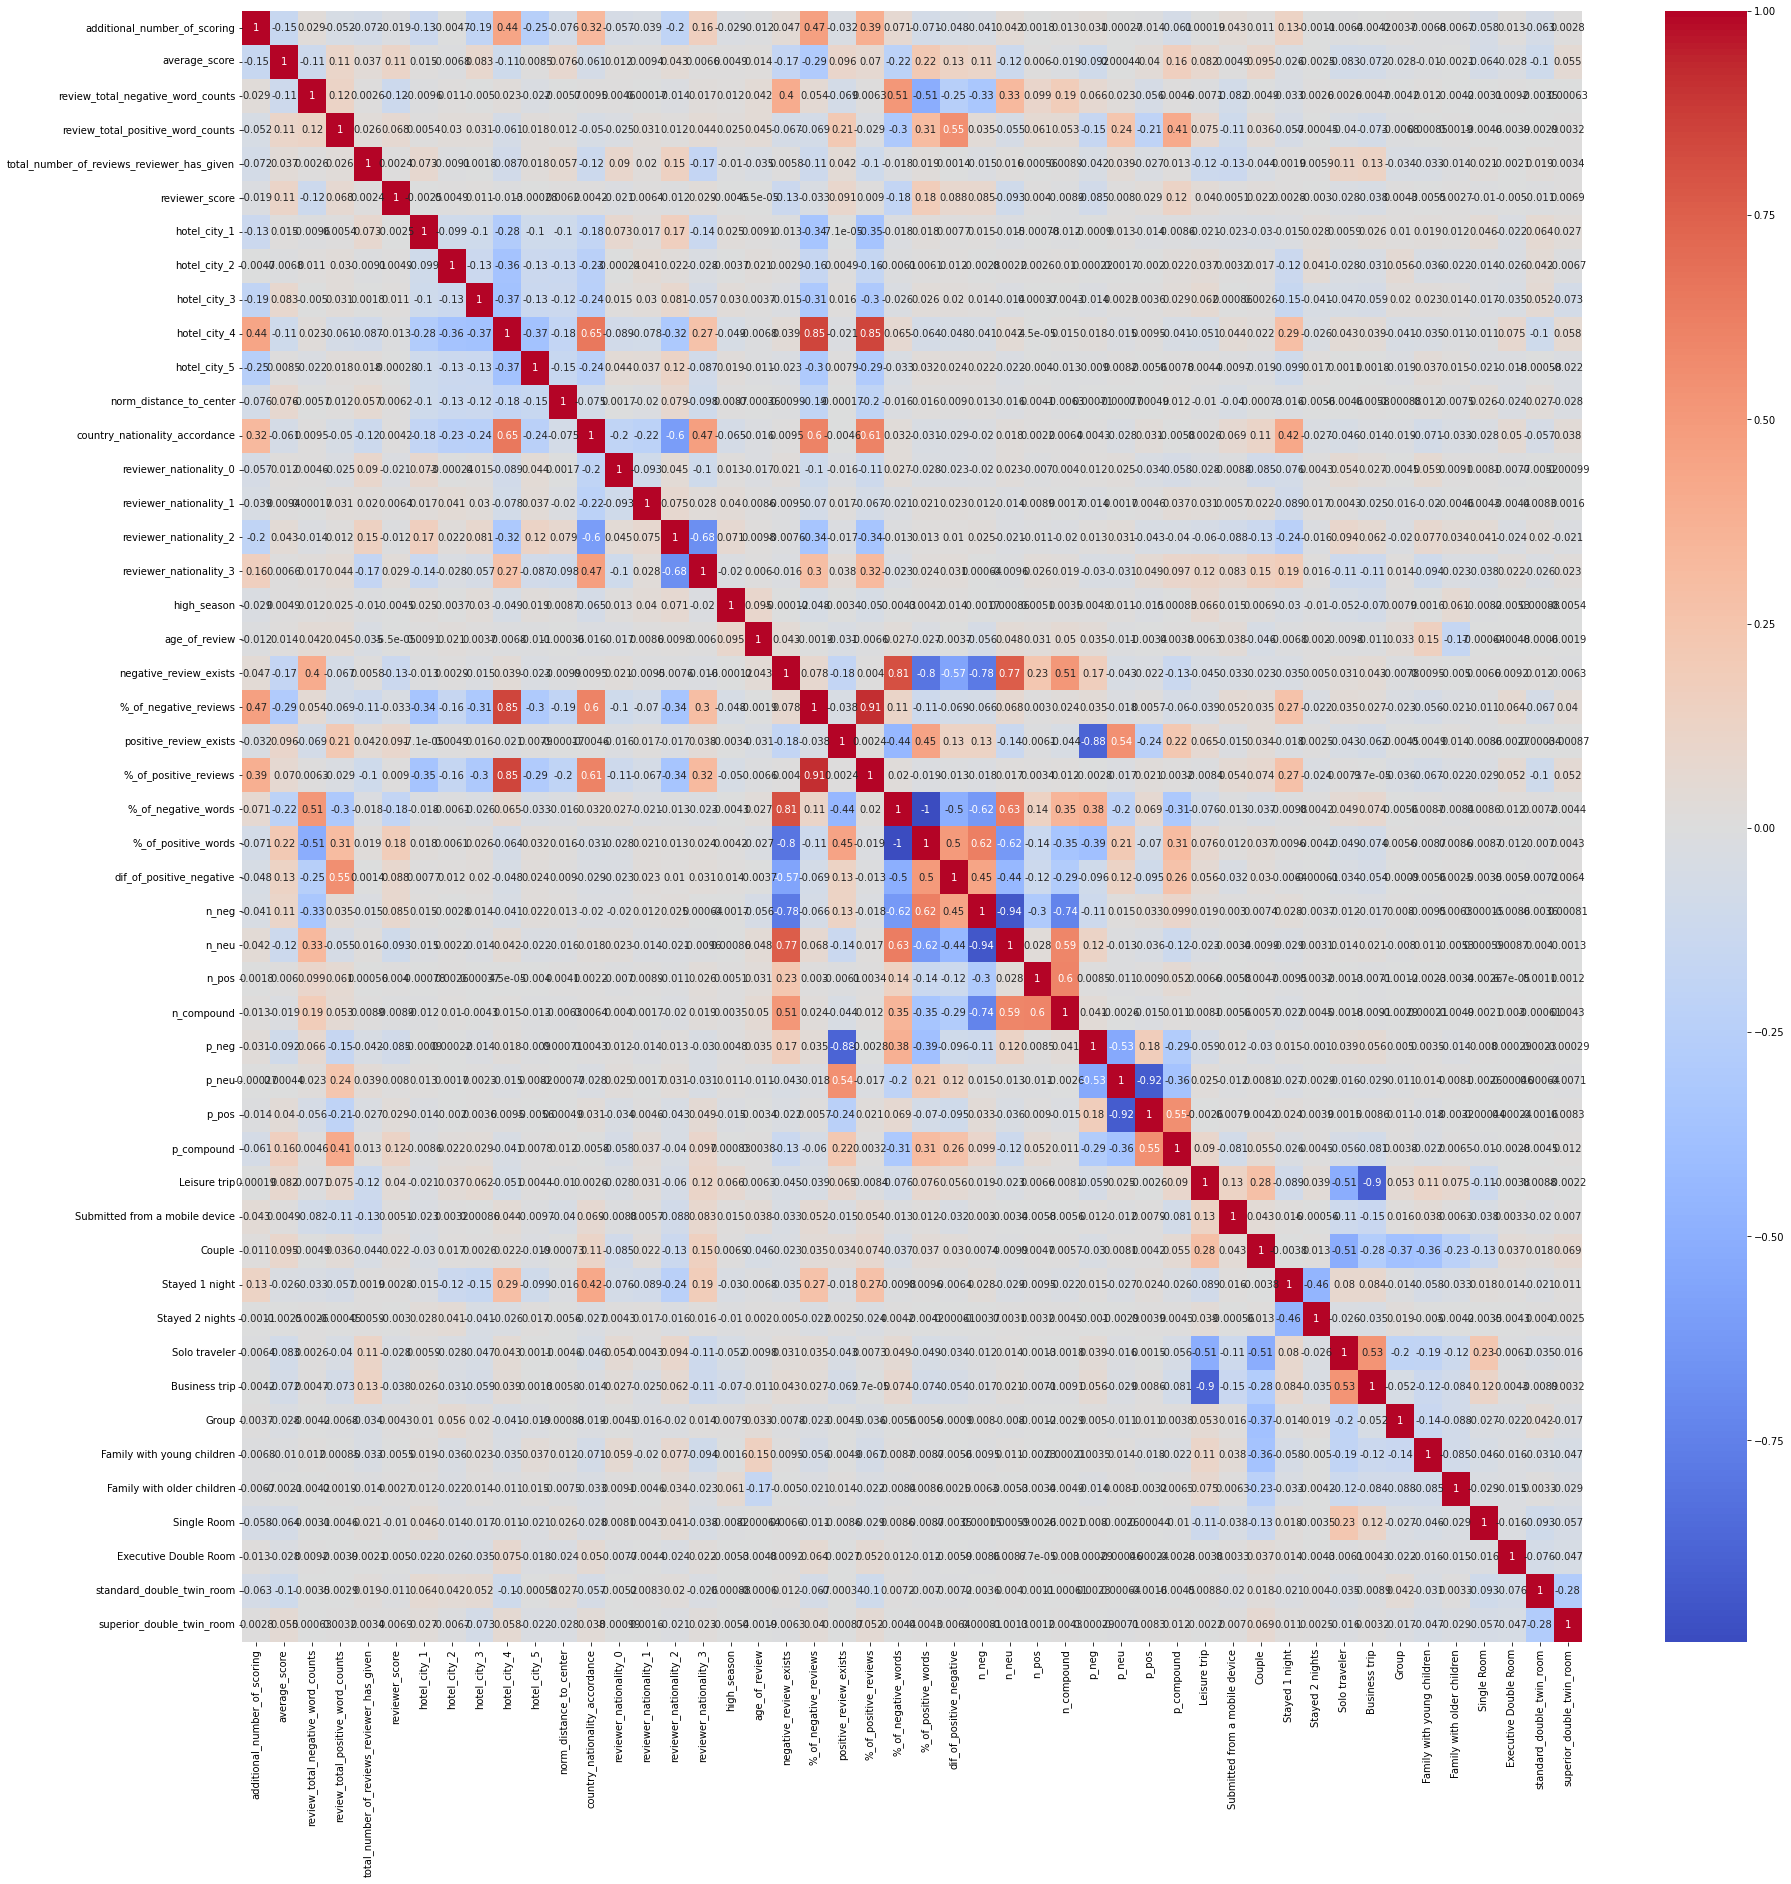

In [742]:
#проверяю признаки на мультиколлинеарность
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True,cmap='coolwarm')

In [743]:
#убираю сильно коррелирующие признаки на основании матрицы
data.drop(['Business trip','%_of_negative_reviews','positive_review_exists','negative_review_exists','n_compound','p_pos','p_neu','n_compound','review_total_negative_word_counts','%_of_positive_words','hotel_city_4'],axis=1,inplace=True)

In [744]:
#убираю неинформативные признаки
data.drop(['additional_number_of_scoring','total_number_of_reviews_reviewer_has_given'],axis=1,inplace=True)

In [745]:
#стандартизирую признаки
col_name= data[['average_score',
                'review_total_positive_word_counts'
               ]]
scaler = preprocessing.StandardScaler()
data_scalar = scaler.fit_transform(col_name)
data_scalar = pd.DataFrame(data_scalar,columns=col_name.columns)

Проверяю признаки на значимость

In [746]:
data.columns

Index(['average_score', 'review_total_positive_word_counts', 'sample',
       'reviewer_score', 'hotel_city_1', 'hotel_city_2', 'hotel_city_3',
       'hotel_city_5', 'norm_distance_to_center',
       'country_nationality_accordance', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'high_season', 'age_of_review',
       '%_of_positive_reviews', '%_of_negative_words',
       'dif_of_positive_negative', 'n_neg', 'n_neu', 'n_pos', 'p_neg',
       'p_compound', 'Leisure trip', 'Submitted from a mobile device',
       'Couple', 'Stayed 1 night', 'Stayed 2 nights', 'Solo traveler', 'Group',
       'Family with young children', 'Family with older children',
       'Single Room', 'Executive Double Room', 'standard_double_twin_room',
       'superior_double_twin_room'],
      dtype='object')

In [747]:
# непрерывные признаки
num_cols = ['average_score','review_total_positive_word_counts','norm_distance_to_center',
            'age_of_review','%_of_positive_reviews','%_of_negative_words',
            'dif_of_positive_negative','n_neg','n_neu','n_pos','p_neg','p_compound']

# категориальные признаки
cat_cols = ['average_score','country_nationality_accordance', 'high_season', 'Leisure trip','Submitted from a mobile device',
            'Couple', 'Stayed 1 night', 'Stayed 2 nights','Group','Family with young children',
            'Family with older children','Single Room','Executive Double Room','standard_double_twin_room',
            'superior_double_twin_room','hotel_city_1','hotel_city_2','hotel_city_3',
        'reviewer_nationality_0','reviewer_nationality_1','reviewer_nationality_2','reviewer_nationality_3']
           

In [748]:
data[num_cols].describe()

,average_score,review_total_positive_word_counts,norm_distance_to_center,age_of_review,%_of_positive_reviews,%_of_negative_words,dif_of_positive_negative,n_neg,n_neu,n_pos,p_neg,p_compound
count,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000,515402.000000
mean,8.397653,16.323934,0.157219,-0.043749,0.302845,0.423420,0.069782,0.322660,0.619026,0.052940,0.034857,0.593602
std,0.548032,21.564137,0.212097,0.633678,0.121141,0.358406,0.150279,0.410262,0.392867,0.115527,0.103425,0.342415
min,5.200000,0.000000,0.000000,-1.181818,0.043478,0.000000,0.000025,0.000000,0.000000,0.000000,0.000000,-0.983200
25%,8.100000,4.000000,0.056041,-0.545455,0.194107,0.000000,0.004000,0.000000,0.000000,0.000000,0.000000,0.350600
50%,8.400000,10.000000,0.078555,0.000000,0.309934,0.444444,0.012273,0.107000,0.781000,0.000000,0.000000,0.708900
75%,8.800000,21.000000,0.145872,0.454545,0.404878,0.736842,0.070000,1.000000,1.000000,0.057000,0.000000,0.883400
max,9.800000,393.000000,1.000000,1.000000,0.579639,1.000000,3.830000,1.000000,1.000000,1.000000,1.000000,0.999300


<AxesSubplot:>

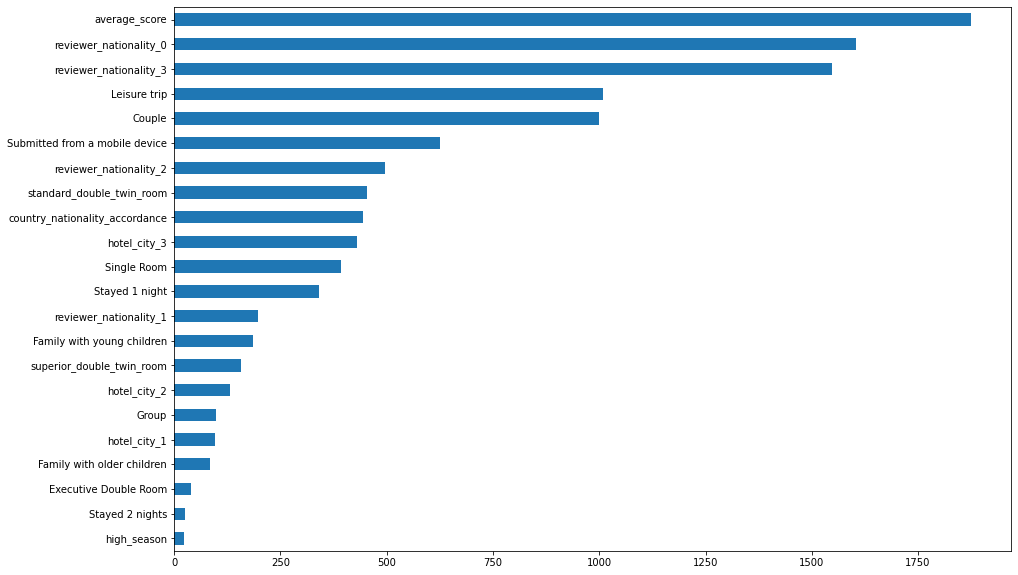

In [749]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

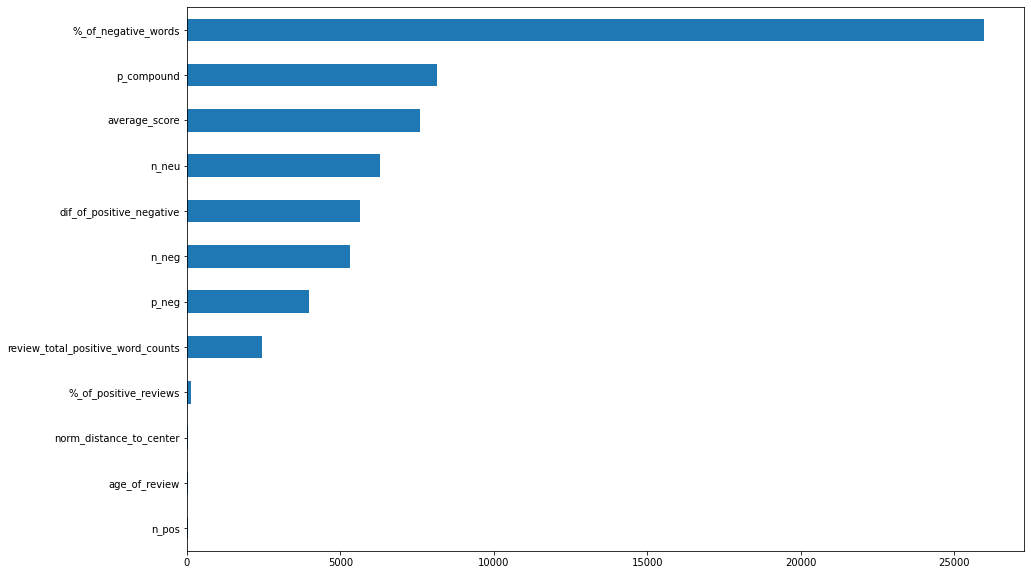

In [750]:
y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

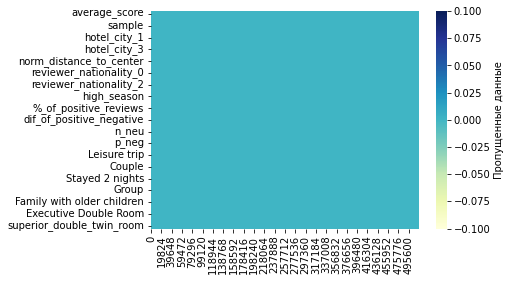

In [751]:
# Визуализация пропусков
plt.figure(figsize=(6,4))
sns.heatmap(data.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Пропущенные данные'})
plt.show()

In [752]:
#проверяю данные на наличие значение np.inf
np.all(np.isfinite(data))

True

# 6. Обучение модели и анализ результатов

In [778]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [779]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [780]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128906, 34), (386496, 34), (386496, 33), (309196, 33), (77300, 33))

In [781]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [782]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [783]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.6s finished


In [784]:
# функция Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [785]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8685097193217517
MAPE: 12.352750433489296


<AxesSubplot:>

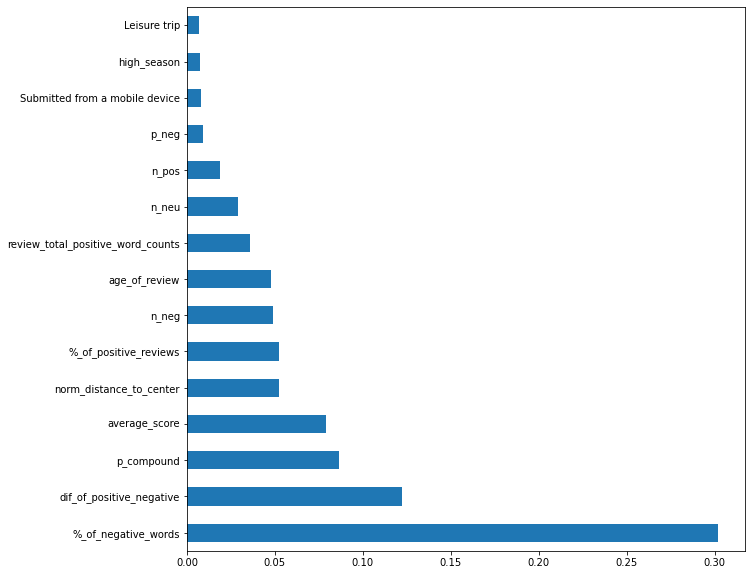

In [774]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [763]:
test_data.sample(10)

,average_score,review_total_positive_word_counts,reviewer_score,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_5,norm_distance_to_center,country_nationality_accordance,reviewer_nationality_0,...,Stayed 1 night,Stayed 2 nights,Solo traveler,Group,Family with young children,Family with older children,Single Room,Executive Double Room,standard_double_twin_room,superior_double_twin_room
72954,7.8,39,0.0,0,0,0,0,0.024457,1,0,...,1,0,0,0,0,0,0,0,1,0
30548,8.7,8,0.0,0,0,0,0,0.400796,1,0,...,1,0,0,0,0,0,0,0,1,0
19159,8.4,1,0.0,0,0,0,0,0.113206,0,0,...,1,0,0,0,1,0,0,0,0,0
87979,9.5,5,0.0,0,0,0,0,0.062376,1,0,...,1,0,0,0,0,0,0,0,0,0
7695,8.1,12,0.0,0,0,0,0,0.065698,1,0,...,1,0,1,0,0,0,0,0,0,1
112744,8.4,8,0.0,0,0,0,0,0.022314,1,0,...,1,0,0,0,0,0,0,0,0,0
88251,8.6,10,0.0,0,0,1,0,0.057344,0,0,...,0,0,0,0,0,1,0,0,0,0
49399,8.2,2,0.0,0,1,0,0,0.118320,0,0,...,0,0,0,1,0,0,0,0,1,0
125942,8.5,4,0.0,0,0,0,0,0.965504,0,0,...,1,0,0,0,1,0,0,0,0,0
7022,8.6,3,0.0,0,0,0,0,0.036621,1,0,...,0,1,1,0,0,0,0,0,0,1


In [764]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [765]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.9s finished


In [766]:
predict_submission

array([8.483, 7.408, 8.346, ..., 7.847, 9.484, 8.083])

In [767]:
list(sample_submission)

['reviewer_score', 'id']

In [768]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

ValueError: Length of values (128906) does not match length of index (128935)